In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import talib
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr, spearmanr
from statsmodels.regression.rolling import RollingOLS


import datetime
import time
import os
import pytz
import json
import csv

from pprint import pprint



In [2]:
# GLOBAL SETTINGS

# Data directories
#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
coin_dataDir = 'DATA/COMBINEDDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/'
model_dataDir = 'DATA/MODELDATA/'
riskFactor_dataDir = 'DATA/RISKFACTORSDATA/'



isdir = os.path.isdir(model_dataDir)

# Date ranges
START = 2020
END = 2022

MONTH = 30
YEAR = 12 * MONTH

# Helpers
idx = pd.IndexSlice
sns.set_style('whitegrid')

# END GLOBAL SETTINGS

In [3]:
# Read in MDF with initial coin pool
cpool_mdf = pd.read_csv(coin_dataDir + 'CoinPool.csv')
cpool_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
cpool_mdf['Dates'] = pd.to_datetime(cpool_mdf['Dates'])
cpool_mdf.set_index(['Dates', 'Coin'], inplace=True)
print('Initial Base Data:'.upper())
print(cpool_mdf.info())


ohlcv = ['Open','High','Low','Close','Volume']
prices_mdf = (cpool_mdf
              .loc[idx[str(START):str(END), :], ohlcv]
              .swaplevel()
              .sort_index())

# want at least X years of data
yr = 2
min_obs = yr * YEAR

# have this much per ticker
nobs = prices_mdf.groupby(level='Coin').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices_mdf = prices_mdf.loc[idx[keep, :], :]
print(f"After dropping coins with less than {yr} years of data".upper())
print(prices_mdf.info())

INITIAL BASE DATA:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78330 entries, (Timestamp('2018-08-24 00:00:00'), 'basic-attention-token') to (Timestamp('2022-02-16 00:00:00'), 'zcash')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        78330 non-null  float64
 1   High        78330 non-null  float64
 2   Low         78330 non-null  float64
 3   Close       78330 non-null  float64
 4   Volume      78330 non-null  float64
 5   Market Cap  78330 non-null  float64
dtypes: float64(6)
memory usage: 3.9+ MB
None
AFTER DROPPING COINS WITH LESS THAN 2 YEARS OF DATA
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43545 entries, ('algorand', Timestamp('2020-01-01 00:00:00')) to ('zcash', Timestamp('2022-02-16 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    43545 non-null  float64
 1   High    43545 non-null  float64
 2   Low    

In [4]:
# Compute Technical Analysis Indicators to be use as momentum alpha factors (The Features)

# Relative Strength Index (RSI)
prices_mdf['RSI'] = prices_mdf.groupby(level='Coin').Close.apply(talib.RSI)

# Bollinger Bands
def compute_bb(close):
    high, mid, low = talib.BBANDS(close, timeperiod=20)
    return pd.DataFrame({'BB_high': high, 'BB_low': low}, index=close.index)

prices_mdf = (prices_mdf.join(prices_mdf
                      .groupby(level='Coin')
                      .Close
                      .apply(compute_bb)))

# Average True Range (ATR)
def compute_atr(coin_data):
    df = talib.ATR(coin_data.High, coin_data.Low,
             coin_data.Close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices_mdf['ATR'] = (prices_mdf.groupby('Coin', group_keys=False)
                 .apply(compute_atr))

# Moving Average Convergence Divergence (MACD)
def compute_macd(close):
    macd = talib.MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices_mdf['MACD'] = (prices_mdf
                  .groupby('Coin', group_keys=False)
                  .Close
                  .apply(compute_macd))


# Stochastic Oscillator (STOCH)
def compute_stoch(coin_data):
    slowk, slowd = talib.STOCH(coin_data.High,
                         coin_data.Low,
                         coin_data.Close,
                         fastk_period=14,
                         slowk_period=3,
                         slowk_matype=0,
                         slowd_period=3,
                         slowd_matype=0)

    return slowd/slowk

prices_mdf['STOCH'] = (prices_mdf
                       .groupby('Coin', group_keys=False)
                       .apply(compute_stoch))

# Average Directional Index (ADX)
def compute_adx(coin_data):
    real = talib.ADX(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

prices_mdf['ADX'] = (prices_mdf
                     .groupby('Coin', group_keys=False)
                     .apply(compute_adx))


#Plus/Minus Directional Index
def compute_diplus(coin_data):
    real = talib.PLUS_DI(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

def compute_diminus(coin_data):
    real = talib.MINUS_DI(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

prices_mdf["DI_PLUS"] = (prices_mdf.groupby('Coin', group_keys=False).apply(compute_diplus))
prices_mdf["DI_MINUS"] = (prices_mdf.groupby('Coin', group_keys=False).apply(compute_diminus))

# Compute lagged returns and Winsorize
#lags = [1, 7, 14, 30, 60, 90]
lags = [1, 7, 14, 30]

q = 0.0001

for lag in lags:
    prices_mdf[f'return_{lag}d'] = (prices_mdf.groupby(level='Coin').Close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )
# Shift lagged returns
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 7, 14, 30]:
#    for lag in [1, 7, 14, 30, 60, 90]:

        prices_mdf[f'return_{lag}d_lag{t}'] = (prices_mdf.groupby(level='Coin')
                                           [f'return_{lag}d'].shift(t * lag))

# Generate target forward returns
#for t in [1, 7, 14, 30, 60, 90]:
for t in [1, 7, 14, 30]:

    prices_mdf[f'target_{t}d'] = prices_mdf.groupby(level='Coin')[f'return_{t}d'].shift(-t)

# Create dummy time variables. USe drop first to avoid creating multicollinearity.
prices_mdf['year'] = prices_mdf.index.get_level_values('Dates').year
prices_mdf['month'] = prices_mdf.index.get_level_values('Dates').month

prices_mdf = pd.get_dummies(prices_mdf,
                        columns=['year', 'month'],
                        prefix=['year', 'month'],
                        prefix_sep=['_', '_'],
                        drop_first=True)


# Read in PCA Risk Factors
risk_factors_df = pd.read_csv(riskFactor_dataDir + 'PCA_Risk_Factors.csv')
risk_factors_df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
risk_factors_df['Dates'] = risk_factors_df['Dates'].astype('datetime64')
risk_factors_df = risk_factors_df.set_index('Dates')
risk_factors_df.drop(risk_factors_df.index[-1], inplace=True)

# Combine them with daily returns
#daily_returns = prices_mdf.loc[:, 'return_1d':'return_90d']
daily_returns = prices_mdf.loc[:, 'return_1d':'return_30d']
factor_betas = daily_returns.join(risk_factors_df).sort_index()

# Get rid of the extra returns
del factor_betas['return_7d']
del factor_betas['return_14d']
del factor_betas['return_30d']
#del factor_betas['return_60d']
#del factor_betas['return_90d']

# Compute the factor Betas with Rolling OLS Regression on the PCA Principal Componenets
T = 30
betas = (factor_betas.groupby(level='Coin',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1d,
                                     exog=sm.add_constant(x.drop('return_1d', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))


factors = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3',
           'Principal Component 4']

# Impute missing Betas
betas = betas.loc[:, factors] = betas.groupby('Coin')[factors].apply(lambda x: x.fillna(x.mean()))
print("Factos Betas:".upper())
print(betas.describe().join(betas.sum(1).describe().to_frame('total')))

# Combine the Factor Betas with the rest of the model
prices_mdf = (prices_mdf
        .join(betas
              .groupby(level='Coin')
              .shift()))

# Immpute the missing factor betas to fill things out
prices_mdf.loc[:, factors] = prices_mdf.groupby('Coin')[factors].apply(lambda x: x.fillna(x.mean()))
print("Features so far".upper())
print(prices_mdf.columns)

FACTOS BETAS:
       Principal Component 1  Principal Component 2  Principal Component 3  \
count           43545.000000           43545.000000           43545.000000   
mean                0.143791               0.019758               0.001681   
std                 0.057981               0.212261               0.219720   
min                -0.234588              -1.697371              -1.303875   
25%                 0.111067              -0.056837              -0.113390   
50%                 0.143077              -0.008615              -0.034049   
75%                 0.174289               0.056534               0.074046   
max                 0.615711               2.377676               2.492495   

       Principal Component 4         total  
count           43545.000000  43545.000000  
mean                0.005554      0.170783  
std                 0.258237      0.408359  
min                -2.341477     -3.325042  
25%                -0.090433     -0.048835  
50%          

In [5]:
prices_mdf

Open        High         Low       Close  \
Coin     Dates                                                        
algorand 2020-01-01    0.218748    0.222235    0.216208    0.217082   
         2020-01-02    0.217110    0.223550    0.212620    0.221130   
         2020-01-03    0.225794    0.228268    0.223328    0.227190   
         2020-01-04    0.228031    0.235819    0.227050    0.235536   
         2020-01-05    0.234223    0.237087    0.229622    0.231797   
...                         ...         ...         ...         ...   
zcash    2022-02-12  118.084425  123.020398  116.057355  117.034307   
         2022-02-13  116.602739  118.807277  113.648429  114.846957   
         2022-02-14  115.443126  124.663050  114.118433  124.663050   
         2022-02-15  124.800243  129.454286  123.071434  123.071434   
         2022-02-16  122.779989  125.943211  120.357825  124.042489   

                           Volume        RSI     BB_high     BB_low       ATR  \
Coin     Dates                                                                  
algorand 2020-01-01  4.797111e+07        NaN         NaN        NaN       NaN   
         2020-01-02  4.736352e+07        NaN         NaN        NaN       NaN   
         2020-01-03  5.333377e+07        NaN         NaN        NaN       NaN   
         2020-01-04  4.896412e+07        NaN         NaN        NaN       NaN   
         2020-01-05  4.876363e+07        NaN         NaN        NaN       NaN   
...                           ...        ...         ...        ...       ...   
zcash    2022-02-12  1.408132e+08  49.813055  137.167120  76.491046 -0.089476   
         2022-02-13  1.361670e+08  48.015676  137.809679  77.921003 -0.121542   
         2022-02-14  1.710199e+08  55.734740  139.260077  79.883055 -0.097401   
         2022-02-15  1.351427e+08  54.326147  139.277192  83.792821 -0.116648   
         2022-02-16  1.768412e+08  55.072192  139.574456  86.943067 -0.142503   

                         MACD  ...  month_7  month_8  month_9  month_10  \
Coin     Dates                 ...                                        
algorand 2020-01-01       NaN  ...        0        0        0         0   
         2020-01-02       NaN  ...        0        0        0         0   
         2020-01-03       NaN  ...        0        0        0         0   
         2020-01-04       NaN  ...        0        0        0         0   
         2020-01-05       NaN  ...        0        0        0         0   
...                       ...  ...      ...      ...      ...       ...   
zcash    2022-02-12 -0.055451  ...        0        0        0         0   
         2022-02-13 -0.076526  ...        0        0        0         0   
         2022-02-14 -0.008685  ...        0        0        0         0   
         2022-02-15  0.030041  ...        0        0        0         0   
         2022-02-16  0.067533  ...        0        0        0         0   

                     month_11  month_12  Principal Component 1  \
Coin     Dates                                                   
algorand 2020-01-01         0         0               0.166933   
         2020-01-02         0         0               0.166942   
         2020-01-03         0         0               0.166942   
         2020-01-04         0         0               0.166942   
         2020-01-05         0         0               0.166942   
...                       ...       ...                    ...   
zcash    2022-02-12         0         0               0.200414   
         2022-02-13         0         0               0.200516   
         2022-02-14         0         0               0.210532   
         2022-02-15         0         0               0.204301   
         2022-02-16         0         0               0.209800   

                     Principal Component 2  Principal Component 3  \
Coin     Dates                                                      
algorand 2020-01-01              -0.013251               0.041022   
       

In [6]:
# Save the model data
if isdir == False:
    os.makedirs(model_dataDir)
    print("Directory '% s' created" % model_dataDir)
    prices_mdf.to_hdf(f'{model_dataDir}model_data.h5', 'model_data')
    prices_mdf.to_csv(f'{model_dataDir}ModelData.csv')
    print(f"The model data has been saved to {model_dataDir} as a MultiIndex dataframe")

else:
    prices_mdf.to_csv(f'{model_dataDir}ModelData.csv')
    prices_mdf.to_hdf(f'{model_dataDir}model_data.h5', 'model_data')
    print(f"The model data has been saved to {model_dataDir} as a MultiIndex dataframe")



The model data has been saved to DATA/MODELDATA/ as a MultiIndex dataframe


Coins with Unique Values:
56


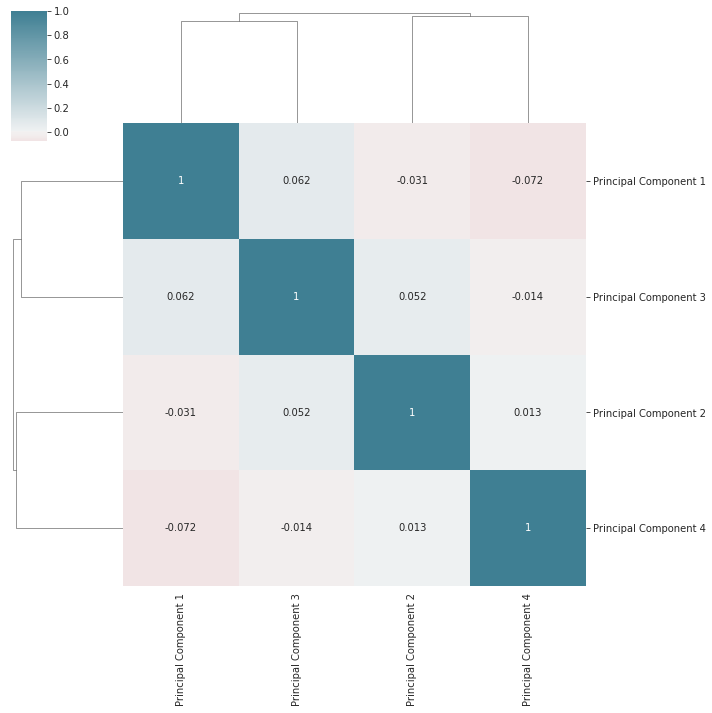

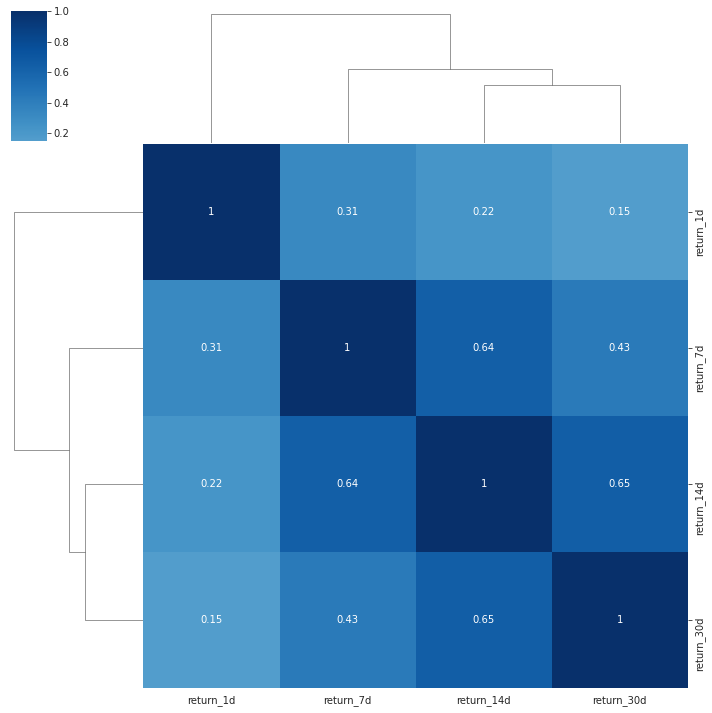

In [7]:
# DATASET INSIGHTS AND VISUALIZATION PLOTS

# Plot correlation custermap of the Betas
cmap = sns.diverging_palette(10, 220, as_cmap=True)
beta_cmap = sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

# Correlation Cluster map of the Returns
#returns = prices_mdf.loc[:, 'return_1d':"return_90d"]
returns = prices_mdf.loc[:, 'return_1d':"return_30d"]
clusterMap = sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap='Blues')
print('Coins with Unique Values:')
print(returns.index.get_level_values('Coin').nunique())

In [8]:
# Check return distributions

#sns_distPlot = sns.distplot(returns['return_90d'])
#fig = sns_distPlot.get_figure()
#sns.despine()

In [9]:
#sns_distPlot = sns.distplot(returns['return_60d'])
#fig = sns_distPlot.get_figure()
#sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


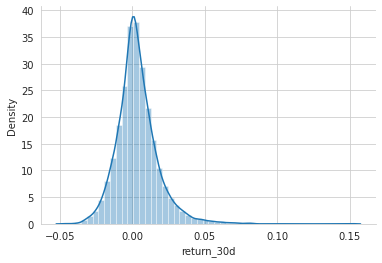

In [10]:
sns_distPlot = sns.distplot(returns['return_30d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


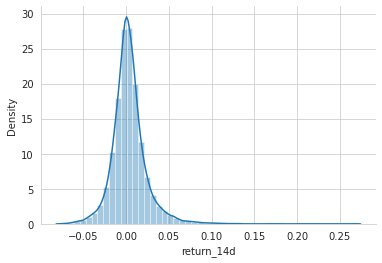

In [11]:
sns_distPlot = sns.distplot(returns['return_14d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


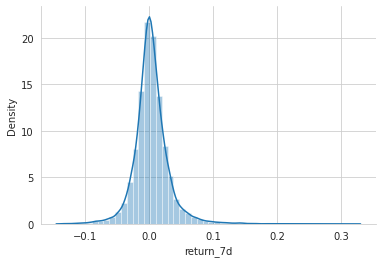

In [12]:
sns_distPlot = sns.distplot(returns['return_7d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


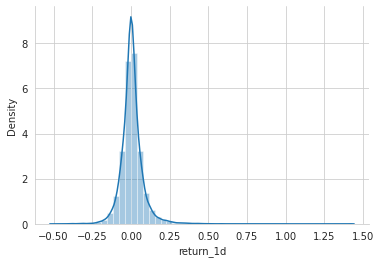

In [13]:
sns_distPlot = sns.distplot(returns['return_1d'])
fig = sns_distPlot.get_figure()
sns.despine()

Daily Returns Spearman
-8.19% (0.00%)


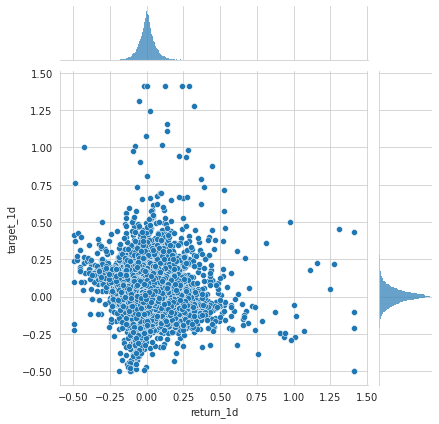

In [14]:
# Spearman Ranks and scatter plots for factors
target = 'target_7d'
price_copy = prices_mdf.copy()

# Daily Returns
daily_target = "target_1d"
metric = 'return_1d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Daily Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')


Weekly Returns Spearman
0.96% (4.74%)


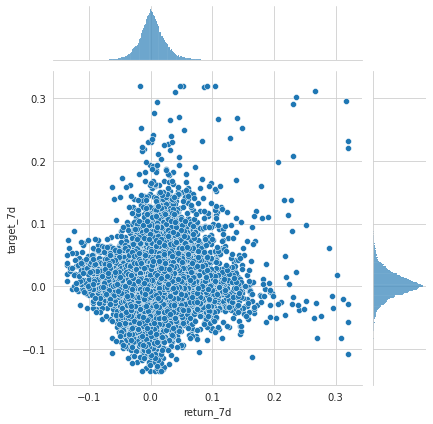

In [15]:
# Weekly Returns
daily_target = "target_7d"
metric = 'return_7d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Weekly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Bi-Weekly Returns Spearman
7.55% (0.00%)


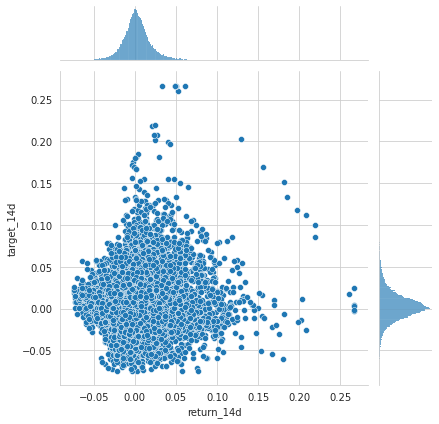

In [16]:
# Bi-Weekly Returns
daily_target = "target_14d"
metric = 'return_14d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Bi-Weekly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Monthly Returns Spearman
5.24% (0.00%)


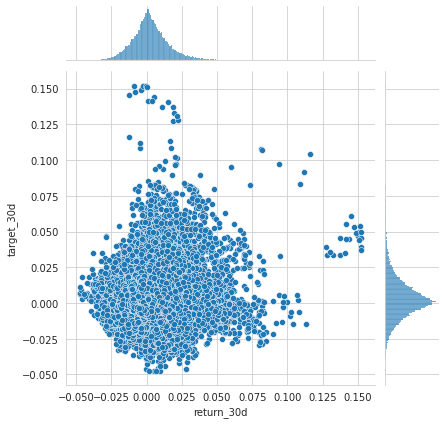

In [17]:
# Monthly Returns
daily_target = "target_30d"
metric = 'return_30d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Monthly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

In [18]:
# Bi-Monthly Returns
#daily_target = "target_60d"
#metric = 'return_60d'
#j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
#df = price_copy[[metric, daily_target]].dropna()
#r, p = spearmanr(df[metric], df[daily_target])
#print("Bi-Monthly Returns Spearman")
#print(f'{r:,.2%} ({p:.2%})')

In [19]:
# Three Month Returns
#daily_target = "target_90d"
#metric = 'return_90d'
#j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
#df = price_copy[[metric, daily_target]].dropna()
#r, p = spearmanr(df[metric], df[daily_target])
#print("Three Month Returns Spearman")
#print(f'{r:,.2%} ({p:.2%})')

Daily RETURNS FEATURE INFO
RSI Distributions
              count      mean       std       min       25%       50%       75%       max
rsi_signal                                                                               
(0, 30]       918.0  0.009935  0.023063 -0.088512 -0.001478  0.009629  0.022610  0.089954
(30, 70]    37434.0  0.002679  0.026823 -0.134887 -0.010334  0.001503  0.014384  0.320332
(70, 100]    4017.0  0.010773  0.039045 -0.113339 -0.012243  0.003746  0.025628  0.320332
RSI Spearman
4.45% (0.00%)


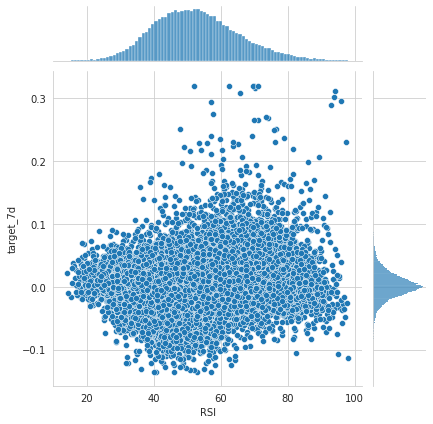

In [20]:
# Relative Strength Index (RSI)
print("Daily RETURNS FEATURE INFO")
price_copy.loc[:, 'rsi_signal'] = pd.cut(price_copy.RSI, bins=[0, 30, 70, 100])
print("RSI Distributions")
print(price_copy.groupby('rsi_signal')['target_7d'].describe().to_string())

metric = "RSI"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("RSI Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)


ADX FEATURE INFO
ADX Distributions
              count      mean       std       min       25%       50%       75%       max
adx_signal                                                                               
(0, 25]     18649.0  0.002570  0.024949 -0.134887 -0.009432  0.001517  0.013150  0.252119
(25, 50]    19928.0  0.004285  0.030064 -0.134887 -0.010560  0.002260  0.017251  0.320332
(50, 75]     3022.0  0.004916  0.036031 -0.107697 -0.016545 -0.000046  0.019381  0.296166
(75, 100]      42.0  0.002831  0.037171 -0.113339 -0.012990 -0.004931  0.024183  0.163885
ADX Spearman
1.32% (0.69%)


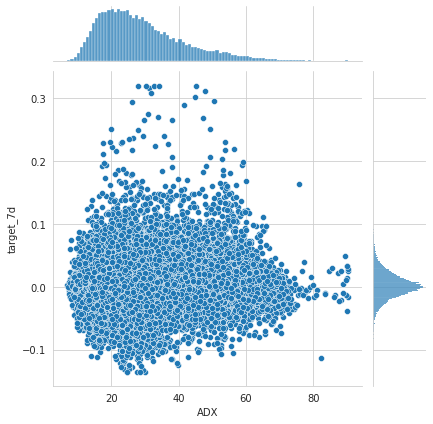

In [21]:
# Average Directional Moving Index (ADX)
print("ADX FEATURE INFO")
price_copy.loc[:, 'adx_signal'] = pd.cut(price_copy.ADX, bins=[0, 25, 50, 75, 100])
print("ADX Distributions")
print(price_copy.groupby('adx_signal')['target_7d'].describe().to_string())

metric = "ADX"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("ADX Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)



DI Plus Spearman
2.08% (0.00%)


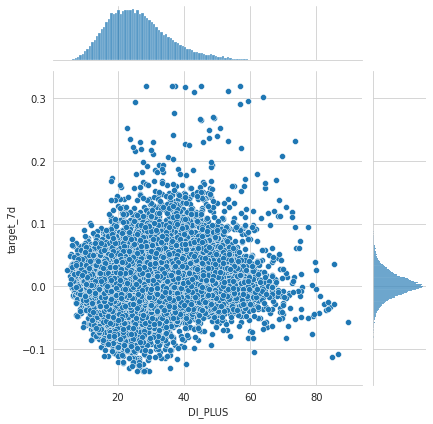

In [22]:
# Directional Indices (DM+/-)
metric = "DI_PLUS"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("DI Plus Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

DI Minus Spearman
-3.37% (0.00%)


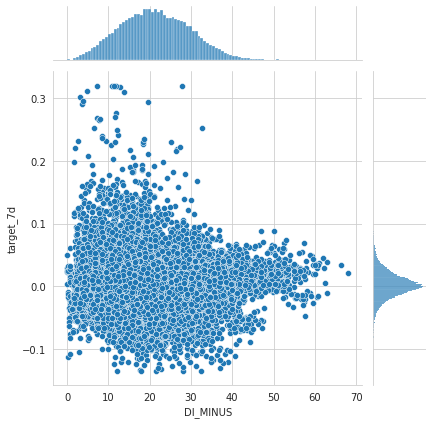

In [23]:
metric = "DI_MINUS"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("DI Minus Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

Lower BB Spearman
-4.46% (0.00%)


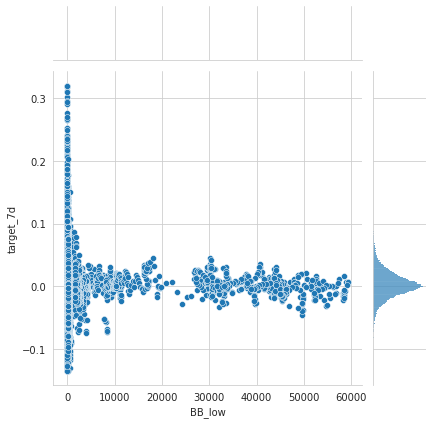

In [24]:
# Bollinger Bands
metric = 'BB_low'
df = price_copy[[metric, target]].dropna()
j=sns.jointplot(x=df[metric], y=df[target], data=df)
r, p = spearmanr(df[metric], df[target])
print("Lower BB Spearman")
print(f'{r:,.2%} ({p:.2%})')


Upper BB Spearman
-4.62% (0.00%)


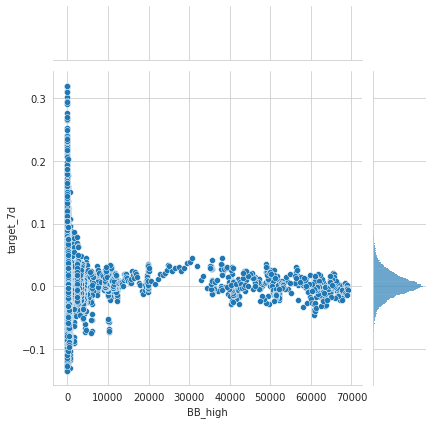

In [25]:
metric = 'BB_high'
df = price_copy[[metric, target]].dropna()
j=sns.jointplot(x=df[metric], y=df[target], data=df)
r, p = spearmanr(df[metric], df[target])
print("Upper BB Spearman")
print(f'{r:,.2%} ({p:.2%})')

ATR Spearman
-13.27% (0.00%)


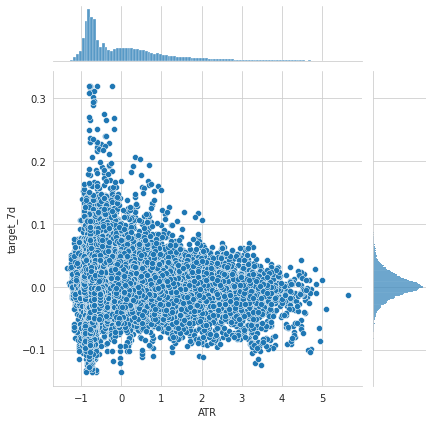

In [26]:
# Active True Range (ATR)
metric = 'ATR'
j=sns.jointplot(x=metric, y=target, data=price_copy)
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("ATR Spearman")
print(f'{r:,.2%} ({p:.2%})')

MACD Spearman
2.77% (0.00%)


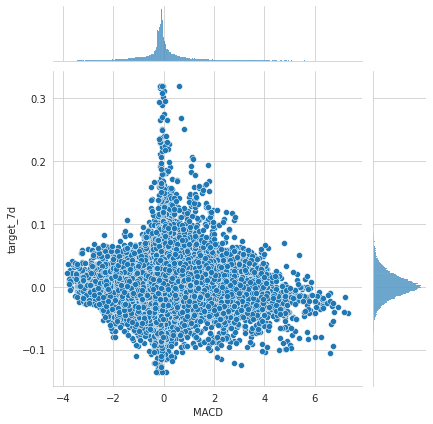

In [27]:
# Moving Average Convegeance Divergeance (MACD)
metric = 'MACD'
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("MACD Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

STOCH Spearman
0.10% (84.28%)


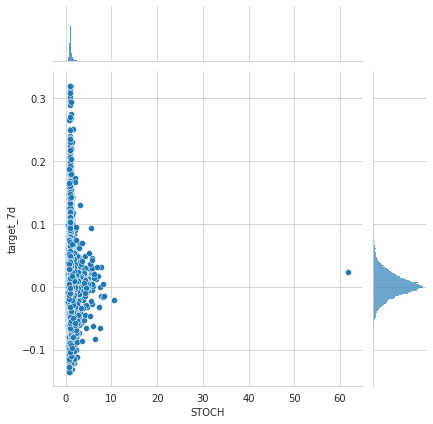

In [28]:
# Stochastic Oscillator
metric = 'STOCH'
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("STOCH Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

In [29]:
# Distribution plots and statistics
print("RETURNS PERCENTILES")
returns = prices_mdf.groupby(level='Coin').Close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
print(returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles'))

RETURNS PERCENTILES
        percentiles
std        0.086068
min       -0.557513
0.01%     -0.497357
0.1%      -0.357802
1%        -0.170276
50%        0.001890
99%        0.248503
99.9%      0.574862
99.99%     1.415256
max        7.870720


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


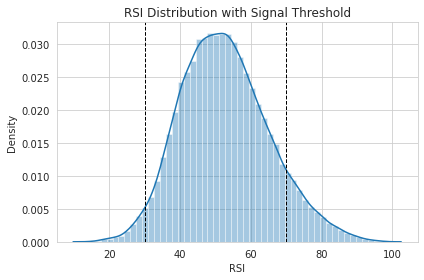

In [30]:
# RSI distplot
RSI_ax = sns.distplot(prices_mdf.RSI.dropna())
RSI_ax.axvline(30, ls='--', lw=1, c='k')
RSI_ax.axvline(70, ls='--', lw=1, c='k')
RSI_ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


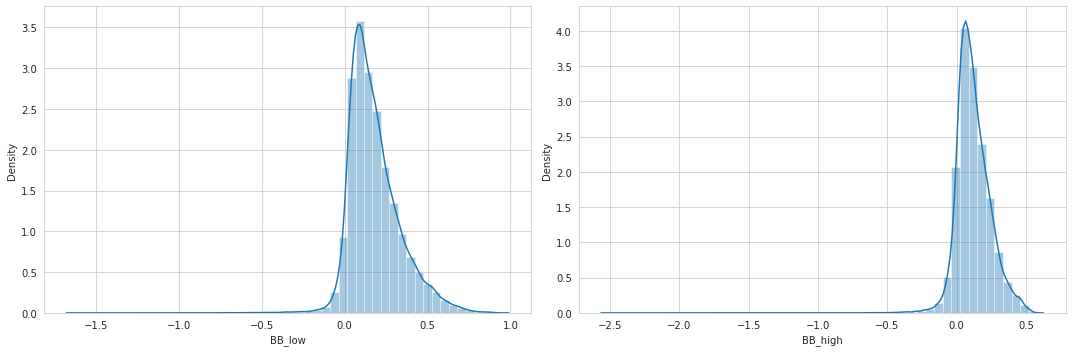

In [31]:
# Bollinger Bands distplot
prices_mdf['BB_high'] = prices_mdf.BB_high.sub(prices_mdf.Close).div(prices_mdf.BB_high).apply(np.log1p)
prices_mdf['BB_low'] = prices_mdf.Close.sub(prices_mdf.BB_low).div(prices_mdf.Close).apply(np.log1p)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices_mdf.BB_low.dropna(), ax=axes[0])
sns.distplot(prices_mdf.BB_high.dropna(), ax=axes[1])
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


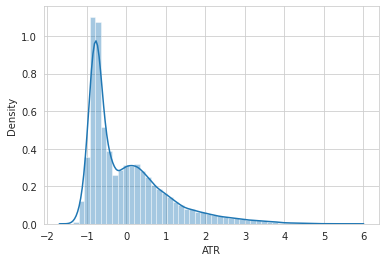

In [32]:
# Average True Range
atr_plot = sns.distplot(prices_mdf.ATR.dropna())
fig = atr_plot.get_figure()

MACD Percentiles
count    41,697.0
mean          0.0
std           1.0
min          -3.8
0.1%         -3.4
1%           -2.5
2%           -2.1
3%           -1.9
4%           -1.7
5%           -1.5
50%          -0.1
95%           1.8
96%           2.0
97%           2.4
98%           2.8
99%           3.6
99.9%         5.8
max           7.4
Name: MACD, dtype: object


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


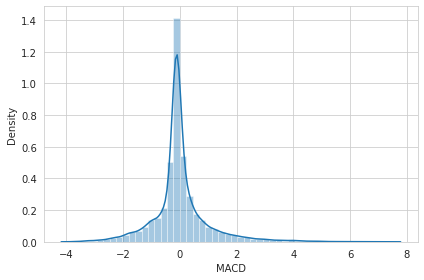

In [33]:
# MACD distribution
print("MACD Percentiles")
print(prices_mdf
      .MACD
      .describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
      .apply(lambda x: f'{x:,.1f}'))

MACD_dist = sns.distplot(prices_mdf.MACD.dropna())
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'ADX Distribution with Signal Threshold')

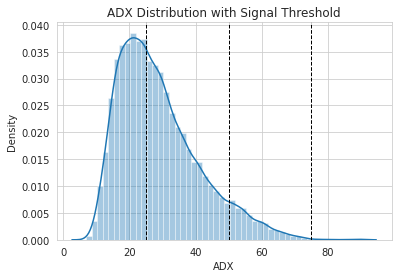

In [34]:
# ADX distribution plot
ADX_dist = sns.distplot(prices_mdf.ADX.dropna())
ADX_dist.axvline(25, ls='--', lw=1, c='k')
ADX_dist.axvline(50, ls='--', lw=1, c='k')
ADX_dist.axvline(75, ls='--', lw=1, c='k')
ADX_dist.set_title('ADX Distribution with Signal Threshold')

STOCH percentiles
count    42,593.0
mean          1.1
std           0.5
min           0.4
0.1%          0.5
1%            0.6
2%            0.6
3%            0.7
4%            0.7
5%            0.7
50%           1.0
95%           1.6
96%           1.6
97%           1.8
98%           1.9
99%           2.3
99.9%         4.8
max          61.8
Name: STOCH, dtype: object


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


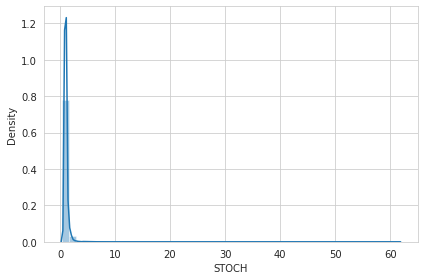

In [35]:
# Stochastic Oscillator distplot
print("STOCH percentiles")
print(prices_mdf
      .STOCH
      .describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
      .apply(lambda x: f'{x:,.1f}'))



STOCH_ax = sns.distplot(prices_mdf.STOCH.dropna())
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


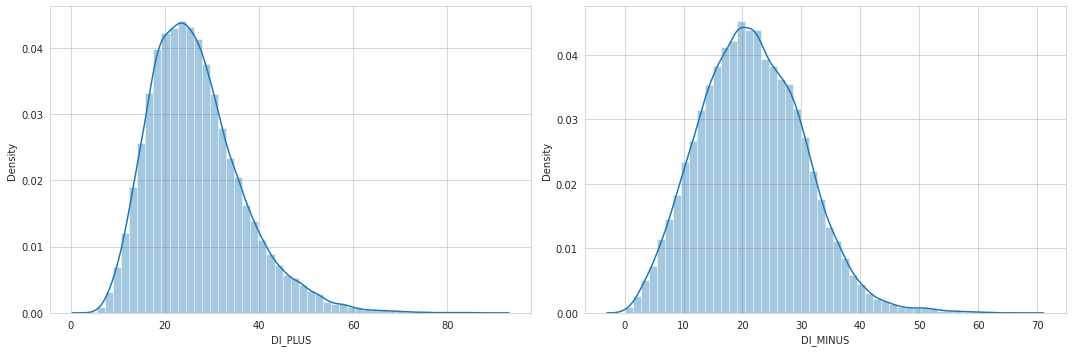

In [36]:
# Directional Indicators (DI +/-)
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices_mdf.DI_PLUS.dropna(), ax=axes[0])
sns.distplot(prices_mdf.DI_MINUS.dropna(), ax=axes[1])
plt.tight_layout()

In [37]:
prices_mdf = (prices_mdf
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High', 'Volume'], axis=1))

In [38]:
# Mutual Information of the Data
#target_labels = [f'target_{i}d' for i in [1,7,14,30,60,90]]
target_labels = [f'target_{i}d' for i in [1,7,14,30]]
targets = prices_mdf.dropna().loc[:, target_labels]

features = prices_mdf.dropna().drop(labels=target_labels, axis=1)
#print(features.columns)
cat_cols = ['year_2021','year_2022', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [39]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [40]:
mutual_info.sum()

target_1d     0.075480
target_7d     0.169974
target_14d    0.251344
target_30d    0.443381
dtype: float64

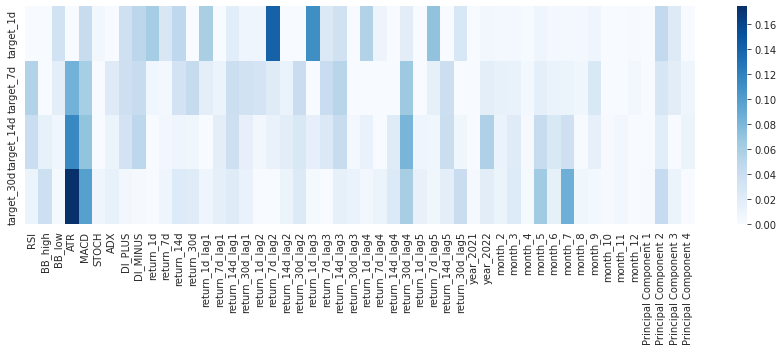

In [41]:
# Normalized Mutual Information(MI) Heatmap
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

In [42]:
dummy_data = pd.get_dummies(prices_mdf,
                            columns=['year_2021', 'year_2022', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31782 entries, ('algorand', Timestamp('2020-06-29 00:00:00')) to ('zcash', Timestamp('2022-01-17 00:00:00'))
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RSI                    31782 non-null  float64
 1   BB_high                31782 non-null  float64
 2   BB_low                 31782 non-null  float64
 3   ATR                    31782 non-null  float64
 4   MACD                   31782 non-null  float64
 5   STOCH                  31782 non-null  float64
 6   ADX                    31782 non-null  float64
 7   DI_PLUS                31782 non-null  float64
 8   DI_MINUS               31782 non-null  float64
 9   return_1d              31782 non-null  float64
 10  return_7d              31782 non-null  float64
 11  return_14d             31782 non-null  float64
 12  return_30d             31782 non-null  float64
 13  return_1d_lag1         

In [43]:
# Dummy Data
#target_labels = [f'target_{i}d' for i in [1,7,14,30,60,90]]
target_labels = [f'target_{i}d' for i in [1,7,14,30]]

dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [44]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [45]:
mutual_info_dummies.sum()

target_1d     0.078884
target_7d     0.191441
target_14d    0.306519
target_30d    0.549904
dtype: float64

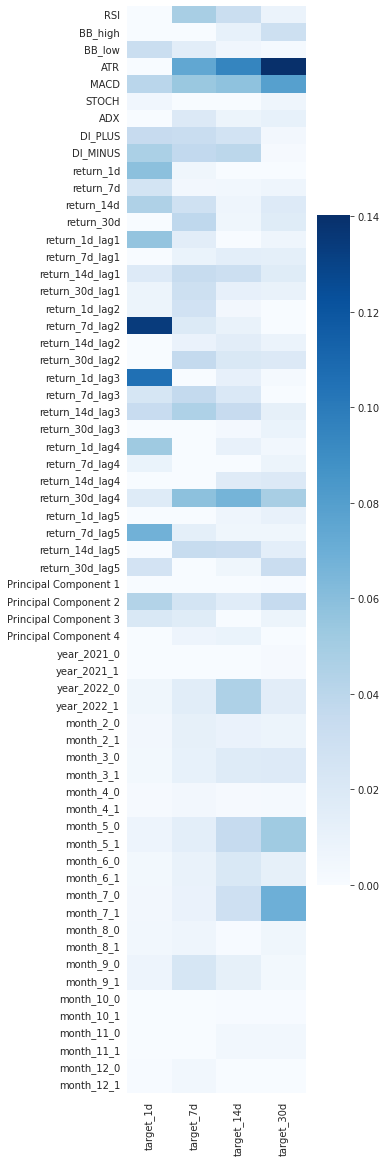

In [46]:
# Dummy Normalized Mutual Information(MI) Heatmap
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');